# **SIFT (Scale-Invariant Feature Transform) Algorithm Overview**

SIFT is a robust computer vision technique for local feature detection and description.

## Steps:

1. **Scale Space:** Build Gaussian pyramids for different scales.
2. **DoG Pyramid:** Compute Difference of Gaussians for keypoint detection.
3. **Keypoint Detection:** Identify potential keypoints from DoG extrema.
4. **Keypoint Refinement:** Refine keypoints based on stability criteria.
5. **Orientation Assignment:** Assign dominant orientations to keypoints.
6. **Descriptor Generation:** Create local feature descriptors around keypoints.
7. **Matching and Recognition:** Match descriptors for object recognition, image stitching, etc.

SIFT's ability to detect and describe robust local features across scales makes it widely used in various computer vision applications.


### We first include necessary libraries and add a normalization function and a function for visualizing images

In [81]:
import matplotlib.pyplot as plt
import numpy as np
from skimage import transform, util
import skimage.io as io
from skimage.color import rgb2gray
from skimage.filters import sobel_h, sobel_v
from skimage.filters import gaussian
from scipy.ndimage import maximum_filter, minimum_filter
from scipy.signal import convolve
from skimage.transform import rotate
import pandas as pd
import cv2
import cProfile
%matplotlib inline

In [2]:
def normalize_img(img):
    """
    Normalize pixel values of an image to the range [0, 1].

    Parameters:
    - img (numpy.ndarray): Input image as a NumPy array.

    Returns:
    - numpy.ndarray: Normalized image with pixel values in the range [0, 1].

    Example:
    >>> img = np.array([[10, 20, 30], [40, 50, 60]])
    >>> normalize_img(img)
    array([[0. , 0.2, 0.4],
           [0.6, 0.8, 1. ]])
    """
    img_min = np.min(img)
    img_max = np.max(img)
    normalized_img = (img - img_min) / (img_max - img_min)
    return normalized_img


In [3]:
def show_images(imgs, imgs_labels=None):
    """
    Display images horizontally using Matplotlib subplots.

    Parameters:
    - imgs: List of images (NumPy arrays) to display.
    - imgs_labels: (Optional) List of labels corresponding to the images.

    Example Usage:
    show_images([image1, image2], ['Label 1', 'Label 2'])
    """
    # Create a figure with subplots based on the number of images
    fig, axes = plt.subplots(1, len(imgs), figsize=(20, 10))

    # Plot each image on its respective subplot
    for i in range(len(imgs)):
        axes[i].imshow(imgs[i], cmap="gray")  # Display image in grayscale
        if imgs_labels:
            axes[i].set_title(imgs_labels[i])  # Set title if labels provided

    # Show the plot
    plt.tight_layout()
    plt.show()


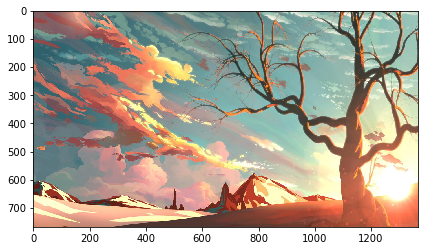

In [70]:
img = io.imread("img.jpg")
io.imshow(img)
plt.show()

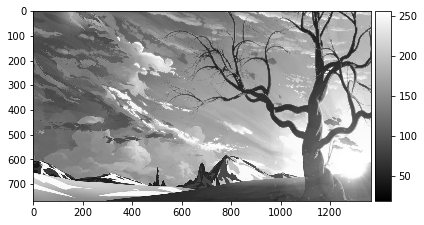

In [71]:
# convert to grayscale
img = (rgb2gray(img) * 256).astype(int)
io.imshow(img, cmap='gray')
plt.show()

## Step1: Build Gaussian pyramids for different scales.


In [77]:
def generate_scale_lvls(img, lvls):
    """
    Generates a list of images by rescaling the input image at different levels.

    Parameters:
    - img: Input image (NumPy array).
    - lvls: List of scaling levels.

    Returns:
    - generated_imgs: List of images rescaled at different levels.
    """
    generated_imgs = [transform.rescale(img, scale=(1.0 / lvl), preserve_range=True) for lvl in lvls]
    return generated_imgs


Wall time: 195 ms


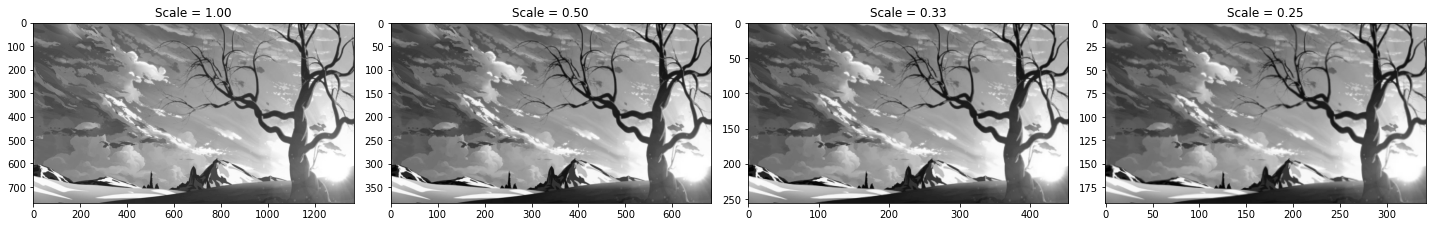

In [84]:
scale_lvls = [1, 2, 3, 4]
%time scaled_imgs = generate_scale_lvls(img, scale_lvls)
show_images(scaled_imgs, [f"Scale = {1/i:.2f}" for i in scale_lvls])

In [85]:
def generate_blur_lvls(img, sigmas):
    """
    Generates a list of images by applying Gaussian blur to the input image at different sigma values.

    Parameters:
    - img: Input image (NumPy array).
    - sigmas: List of sigma values for Gaussian blurring.

    Returns:
    - generated_imgs: List of images blurred at different sigma values.
    """
    generated_imgs = [gaussian(img, sigma=sigma) for sigma in sigmas]
    return generated_imgs


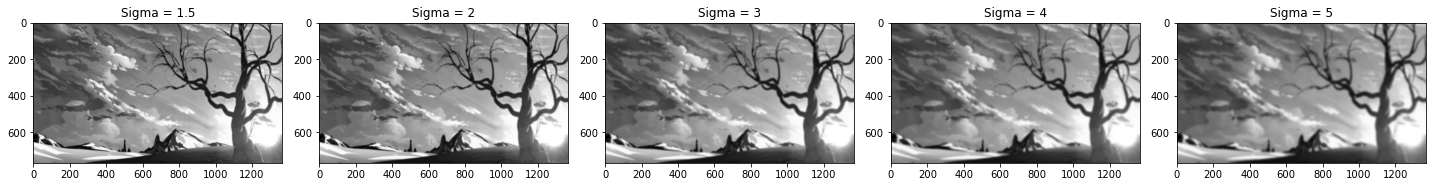

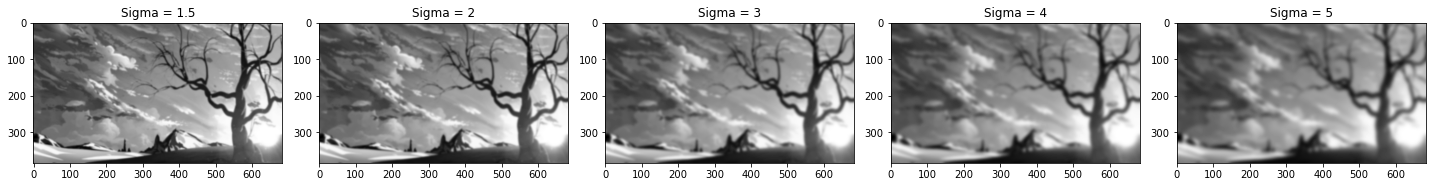

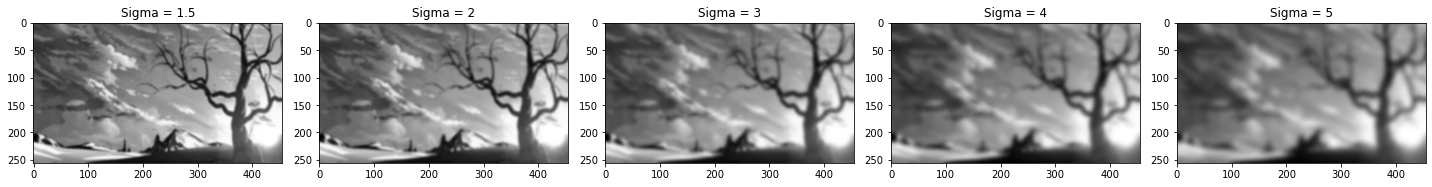

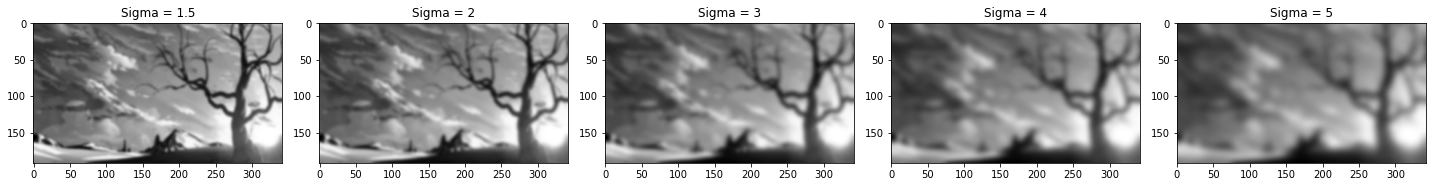

In [86]:
scale_space = []
sigmas = [1.5 ,2, 3, 4, 5]
for i in range(len(scaled_imgs)):
    blurred_imgs = generate_blur_lvls(scaled_imgs[i], sigmas)
    show_images(blurred_imgs, [f"Sigma = {i}" for i in sigmas])
    scale_space.append(blurred_imgs)

## Step2: Compute Difference of Gaussians for keypoint detection.

In [87]:
def DoG(imgs_list):
    """
    Computes the Difference of Gaussians (DoG) for a list of images.

    Parameters:
    - imgs_list: List of images.

    Returns:
    - DoG_list: List of images representing the differences between consecutive scales.
    """
    DoG_list = [imgs_list[i] - imgs_list[i - 1] for i in range(1, len(imgs_list))]
    return DoG_list

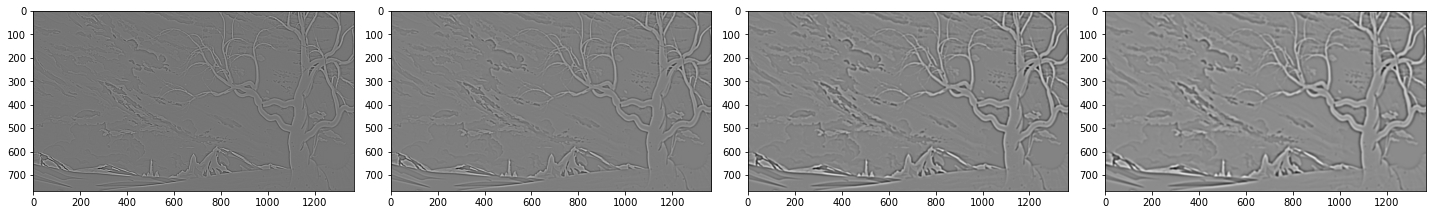

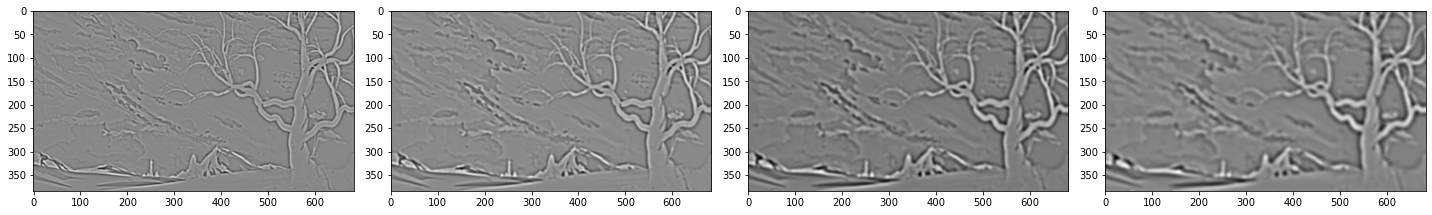

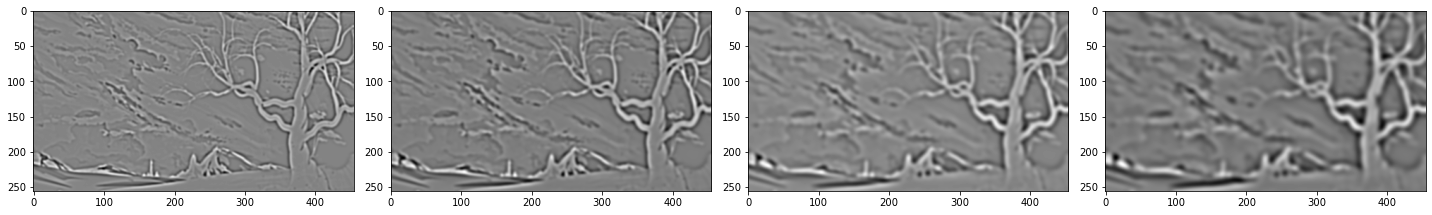

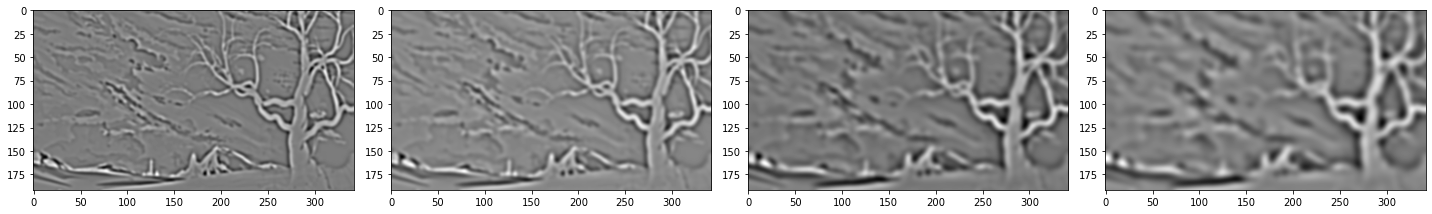

In [88]:
DoG_space = []
for imgs_list in scale_space:
    DoG_list = DoG(imgs_list)
    DoG_space.append(DoG_list)
    show_images(DoG_list)

## Step3: Keypoint Detection
Identify potential keypoints from DoG extrema.

A keypoint in an image is a corner point, and in order to determine whether a point is a corner point or not, we use something called *Harris corner detector*

The Harris corner detector is an algorithm used in computer vision to identify corners or interest points in an image. It's not specifically an edge detector but is often used alongside edge detection methods for feature extraction.

#### Functionality

The Harris corner detection algorithm operates by:

1. **Image Gradients:**
   - Calculating gradients in the image to find changes in intensity in both x and y directions.

2. **Structure Tensor Calculation:**
   - Computing the structure tensor for each pixel, involving the products of gradients.

3. **Sum of Squares of Gradients:**
   - Calculating the sum of squares of gradients using the structure tensor elements.

4. **Corner Response Function:**
   - The cornerstone of the Harris corner detection algorithm is the corner response function.
   - It evaluates the local change in intensity for small displacements in different directions around a pixel.
   - The function assesses the significance of intensity changes when the image is shifted.
   - Mathematically, the corner response function is defined as:
     ```
     R = det(M) - k * trace(M)^2
     ```
     - Where:
       - `det(M)` is the determinant of the structure tensor `M`.
       - `trace(M)` is the trace of the structure tensor `M`.
       - `k` is an empirically determined constant (typically 0.04 to 0.06).
   - Higher values of `R` indicate a stronger response and a higher likelihood of the pixel being part of a corner or an interest point.

5. **Thresholding or Non-Maximum Suppression:**
   - Applying a threshold or non-maximum suppression to the computed corner response values to identify potential corners or interest points.


In [133]:
class Keypoint:
    def __init__(self, x, y, scale=None, theta=None, d_vector=None):
        self.x = x
        self.y = y
        self.theta = theta
        self.scale = scale
        self.descriptor = d_vector


In [136]:

def get_keypoints(DoG_list, thresh=0.03):  # check that image values are between 0 and 1
    """
    Detects potential keypoints in Difference of Gaussian (DoG) images.

    Args:
    - DoG_list (list of arrays): A list containing Difference of Gaussian images.
    - thresh (float): Threshold value for identifying potential keypoints (default: 0.55).

    Returns:
    - total_keypoints (list of lists of tuples): A list containing coordinates of identified keypoints for each DoG image.

    Notes:
    - The function iterates through the DoG images in 'DoG_list' and identifies potential keypoints.
    - 'thresh' determines the sensitivity of keypoint detection.
    - Output 'total_keypoints' contains lists of keypoints corresponding to each DoG image.
    """
    candidate_keypoints = []
    H, W = DoG_list[0].shape
    
    for i in range(1, len(DoG_list)-1):
        full_tensor = np.stack(DoG_list[i-1 : i+2], axis=0)
        for y in range(1, H-1):
            for x in range(1, W-1):
                if(DoG_list[i][y, x] > thresh):
                    tensor = full_tensor[:, y-1:y+2, x-1:x+2]
                    if(DoG_list[i][y, x] == np.max(tensor) or DoG_list[i][y, x] == np.min(tensor)):
                        candidate_keypoints.append(Keypoint(x, y))
    
    return candidate_keypoints


In [137]:
%time keypoints = get_keypoints(DoG_space[0], 0.03)

Wall time: 13.9 s


In [ ]:
# Combine prev function and the following function in one function

## Step4: Keypoint Refinement
Refine keypoints based on stability criteria.

In [113]:
def filter_keypoints(keypoints, img, r=5):
    """
    Refines detected keypoints by filtering based on the Hessian matrix.

    Args:
    - keypoints (list of tuples): Coordinates of keypoints [(x1, y1), (x2, y2), ...].
    - img (numpy array): The image array where keypoints are detected.
    - r (int): Parameter used for Hessian matrix filtering (default: 6).

    Returns:
    - filtered_keypoints (list of tuples): Refined keypoints after filtering.
    - orientation_data (dictionary): Orientation data associated with keypoints.

    Notes:
    - The function refines keypoints based on the Hessian matrix computed at each keypoint location.
    - 'r' influences the filtering process using a ratio threshold with Hessian matrix eigenvalues.
    - Output 'filtered_keypoints' contains refined keypoints passing the Hessian matrix filtering.
    - 'orientation_data' stores magnitude and angle information for refined keypoints.
    """
    filtered_keypoints = []
    orientation_data = {}

    for kp in keypoints:
        x, y = kp

        # Calculate the Hessian matrix at the keypoint location
        patch_size = 5  # Size of the neighborhood patch for computing derivatives
        patch = img[int(y - patch_size/2):int(y + patch_size/2 + 1),
                    int(x - patch_size/2):int(x + patch_size/2 + 1)]

        if patch.any():
            grad_x = sobel_h(patch)
            grad_y = sobel_v(patch)
            dxx = sobel_h(grad_x)
            dyy = sobel_v(grad_y)
            dxy = sobel_h(grad_y)
            dyx = sobel_v(grad_x)

            # Construct the Hessian matrix
            H = np.array([[np.sum(dxx**2), np.sum(dxy**2)],
                           [np.sum(dxy**2), np.sum(dyy**2)]])

            ratio = (H[0, 0] + H[1, 1])**2 / (np.linalg.det(H) + 1e-8)
            if ratio < ((r + 1)**2) / r:
                filtered_keypoints.append((x, y))
                magnitude = np.sqrt(grad_x ** 2 + grad_y ** 2)
                angle = np.arctan2(grad_x, grad_y) * 180 / np.pi
                orientation_data[(x, y)] = (magnitude, angle)

    return filtered_keypoints, orientation_data


In [114]:
filtered_keypoints1, orientation_data1 = filter_keypoints(keypoints[0], DoG_space[0][1])
filtered_keypoints2, orientation_data2 = filter_keypoints(keypoints[1], DoG_space[0][2])

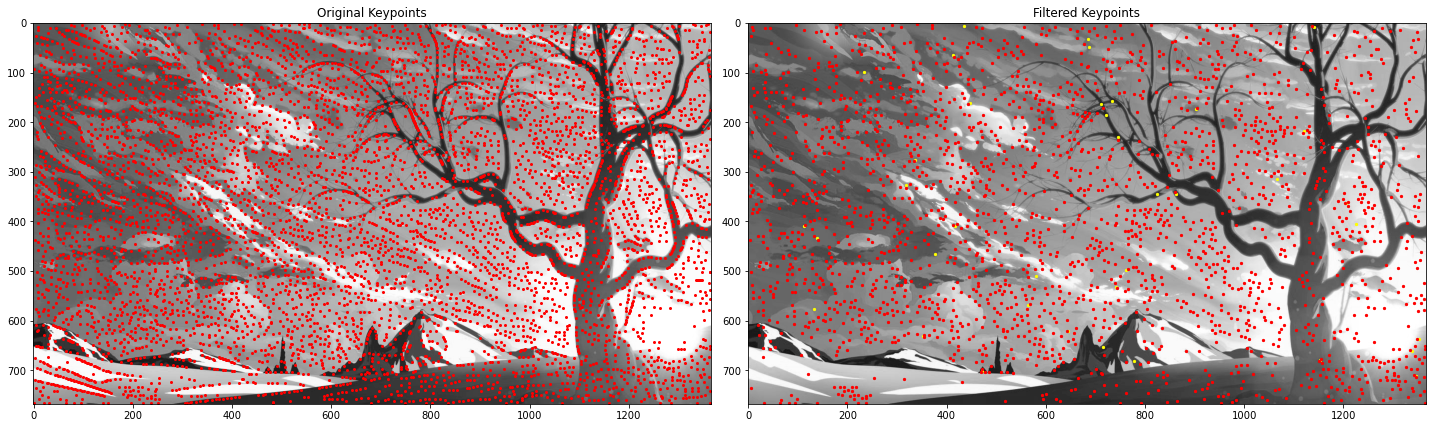

In [115]:
# plot keypoints before and after refinement
keypointsarr = np.array(keypoints[0])
plt.figure(figsize=(20, 7))

plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.scatter(keypointsarr[:, 0], keypointsarr[:, 1], s=4, c="red")
plt.title('Original Keypoints')

# Filtered Keypoints plot
keypointsarr_filtered1 = np.array(filtered_keypoints1)
keypointsarr_filtered2 = np.array(filtered_keypoints2)

plt.subplot(1, 2, 2)
plt.imshow(img, cmap='gray')
plt.scatter(keypointsarr_filtered2[:, 0], keypointsarr_filtered2[:, 1], s=5, c="yellow")
plt.scatter(keypointsarr_filtered1[:, 0], keypointsarr_filtered1[:, 1], s=5, c="red")
plt.title('Filtered Keypoints')

plt.tight_layout()
plt.show()

## Step5: Orientation Assignment
Assign dominant orientations to keypoints.

In [17]:
def get_dominant_angles(filtered_keypoints, orientation_data):
    """
    Determines the dominant angles associated with filtered keypoints.

    Args:
    - filtered_keypoints (list of tuples): Refined keypoints after filtering.
    - orientation_data (dictionary): Contains magnitude and angle information associated with keypoints.

    Returns:
    - new_orientations_data (dictionary): Contains dominant angle(s) associated with filtered keypoints.

    Notes:
    - This function computes the dominant angle(s) for each filtered keypoint based on orientation data.
    - 'filtered_keypoints' represents keypoints refined through a previous filtering process.
    - 'orientation_data' stores magnitude and angle information for each keypoint.
    - Output 'new_orientations_data' contains the dominant angle(s) for the filtered keypoints.
    - A histogram of angles is generated, and the highest peak represents the dominant orientation.
    - Additional angles exceeding 0.8 times the peak value are considered as alternative orientations.
    """
    new_orientations_data = {}

    for kp in filtered_keypoints:
        magnitude, angle = orientation_data[kp]
        hist, bin_edges = np.histogram(angle.flatten(), bins=36, range=(0, 360), weights=magnitude.flatten())
        orientation = np.argmax(hist)
        new_orientations_data[kp] = [orientation]

        # Check for additional prominent angles (>0.8 times the peak value)
        hist = np.delete(hist, orientation)
        other_thetas = np.argwhere(hist > 0.8).reshape(-1)

        if len(other_thetas) > 0:
            new_orientations_data[kp].extend(other_thetas)

    return new_orientations_data


## Step 6: Descriptor Generation
Create local feature descriptors around keypoints.

In [18]:
def get_hist(array, nbins=8):
    """
    Computes a histogram of gradient orientations from an input array.

    Args:
    - array (numpy array): Input array to compute the gradient orientations.
    - nbins (int): Number of bins for the histogram (default: 8).

    Returns:
    - hist (list): Histogram of gradient orientations.

    Notes:
    - Computes gradient magnitudes and angles using Sobel operators on the input array.
    - Generates a histogram of gradient angles with specified bins and magnitude weights.
    - 'nbins' determines the number of bins for the histogram.
    - Output 'hist' contains the histogram of gradient orientations.
    """
    grad_x = sobel_h(array)
    grad_y = sobel_v(array)
    magnitude = np.sqrt(grad_x ** 2 + grad_y ** 2)
    angle = np.arctan2(grad_x, grad_y) * 180 / np.pi

    distances = np.ones(16) * 8
    distances[5:7] = 1
    distances[9:11] = 1
    weights = 1 / (1 + distances)
    
    hist, bin_edges = np.histogram(angle.flatten(), bins=nbins, 
                   range=(0, 360), weights=weights * magnitude.flatten())
    return list(hist)


In [19]:
def get_descriptor(image, kp, rot_angle, patch_size=16, subarray_size=4, func=get_hist):
    """
    Generates a feature descriptor for a keypoint in an image.

    Args:
    - image (numpy array): The image array containing the keypoint.
    - kp (tuple): Coordinates of the keypoint (x, y).
    - rot_angle (float): Rotation angle for the descriptor.
    - patch_size (int): Size of the patch around the keypoint (default: 16).
    - subarray_size (int): Size of subarrays within the patch (default: 4).
    - func (function): Function to compute histogram (default: get_hist).

    Returns:
    - normalized_feature_vector (numpy array): Normalized feature descriptor for the keypoint.

    Notes:
    - Computes a descriptor for a keypoint by dividing the patch into subarrays.
    - Uses a specified function to compute histograms for each subarray.
    - 'patch_size' defines the size of the patch around the keypoint.
    - 'subarray_size' specifies the size of subarrays within the patch.
    - 'func' can be replaced with a different function for histogram computation.
    - Returns a normalized feature vector as the descriptor for the keypoint.
    """
    half_patch = patch_size // 2
    
    x, y = kp
    # Check boundaries
    x_start = max(x - half_patch, 0)
    y_start = max(y - half_patch, 0)
    x_end = min(x + half_patch, image.shape[1] - 1)
    y_end = min(y + half_patch, image.shape[0] - 1)
    
    patch = image[y_start:y_end + 1, x_start:x_end + 1]
    if patch.shape != (17, 17):
        return []
    
    # rotate patch with the dominant angle
    patch = rotate(patch, rot_angle)
    feature_vector = []
    for row in range(0, patch_size, subarray_size):
        for col in range(0, patch_size, subarray_size):
            subarray = patch[row:min(row + subarray_size, patch_size), col:min(col + subarray_size, patch_size)]
            result = func(subarray)
            feature_vector.extend(result)

    normalized_feature_vector = feature_vector / np.linalg.norm(feature_vector)
    return normalized_feature_vector


In [116]:
def get_SIFT_data(img, scale_lvls, sigmas, DoG_thresh=0.03, r=10, generate_scale=True):
    """
    Extracts Scale-Invariant Feature Transform (SIFT) data from an input image.

    Args:
    - img (numpy array): The input image array.
    - scale_lvls (list): List of scale levels for image pyramid generation.
    - sigmas (list): List of sigma values for Gaussian blurring at each scale level.
    - DoG_thresh (float): Threshold value for Difference of Gaussians (DoG) keypoint detection (default: 0.55).
    - r (int): Sensitivity parameter for keypoint filtering using the Hessian matrix (default: 6).

    Returns:
    - SIFT_summary (DataFrame): DataFrame containing SIFT data (Position, Scale, Orientation, Descriptor).

    Notes:
    - Computes an image pyramid with specified scale levels and Gaussian blur at different sigmas.
    - Detects keypoints using Difference of Gaussians (DoG) and filters them based on Hessian matrix analysis.
    - Determines dominant angles for filtered keypoints and computes descriptors.
    - Returns a summary DataFrame containing Position, Scale, Orientation, and Descriptor for each keypoint.
    - 'DoG_thresh' influences keypoint detection sensitivity in the Difference of Gaussians (DoG) process.
    - 'r' parameter affects keypoint filtering based on the Hessian matrix eigenvalues.
    """
    SIFT_summary = pd.DataFrame(columns=["Position", "Scale", "Orientation", "Descriptor"])
    
    # if we are comparing two images we don't want to generate different scales for both images
    if generate_scale:
        scaled_imgs = generate_scale_lvls(img, scale_lvls)
    else:
        scaled_imgs = [img]
    
    scale_space = []
    for i in range(len(scaled_imgs)):
        blurred_imgs = generate_blur_lvls(scaled_imgs[i], sigmas)
        scale_space.append(blurred_imgs)

    for s, imgs_list in enumerate(scale_space):
        DoG_list = DoG(imgs_list)    
        keypoints_list = get_keypoints(DoG_list, DoG_thresh)

        for j in range(len(keypoints_list)):
            filtered_keypoints, orientation_data = filter_keypoints(keypoints_list[j], DoG_list[j + 1], r)
            orientation_data = get_dominant_angles(filtered_keypoints, orientation_data)
    
    for kp in filtered_keypoints:
                for angle in orientation_data[kp]:
                    descriptor = get_descriptor(DoG_list[j + 1], kp, angle)
                    if len(descriptor):
                        data = [kp, scale_lvls[s], angle, descriptor]
                        SIFT_summary.loc[len(SIFT_summary)] = data
    return SIFT_summary

# Modify this function to return Only list of descriptors and a list of keypoints

In [119]:
sigmas = [1.5 ,2, 3, 4, 5]
scale_lvls = [1, 1.33, 2, 4]
%time SIFT_summary = get_SIFT_data(img, scale_lvls, sigmas)

Wall time: 5min 48s


In [22]:
x, y = zip(*SIFT_summary['Position'].to_list())
x = list(x)
y = list(y)

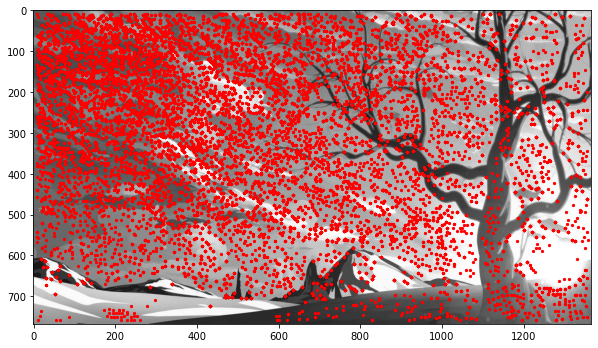

In [23]:
fig = plt.figure(figsize=(10, 8))
plt.imshow(img, cmap='gray')  # Display the image
plt.scatter(x, y, color='red', s=5)  # Scatter plot the point (x, y) in red color
plt.show()

In [24]:
SIFT_summary.tail(10)

Position Scale Orientation  \
32402    (70, 62)     4          11   
32403    (70, 62)     4          13   
32404   (94, 108)     4          10   
32405   (94, 108)     4           8   
32406   (94, 108)     4           9   
32407   (94, 108)     4          10   
32408   (94, 108)     4          11   
32409   (94, 108)     4          12   
32410   (94, 108)     4          13   
32411  (142, 157)     4           2   

                                              Descriptor  
32402  [0.0, 0.15244373648986295, 0.1665205558908636,...  
32403  [0.0, 0.13804944428238428, 0.15523654274867923...  
32404  [0.0, 0.030072540817938517, 0.1614197681360922...  
32405  [0.0, 0.09197182804135007, 0.1387427632641518,...  
32406  [0.0, 0.08403644674910467, 0.12042533566777916...  
32407  [0.0, 0.030072540817938517, 0.1614197681360922...  
32408  [0.0, 0.029673260660575258, 0.1562310892244937...  
32409  [0.0, 0.029141267616810015, 0.1523838480245654...  
32410  [0.0, 0.0221558106573895, 0.15423335361051216,...  
32411  [0.009688090376231162, 0.11521764700633058, 0....

## Nearest Neighbor search between two images to find similar keypoints

In [25]:
from sklearn.neighbors import NearestNeighbors

In [26]:
nn = NearestNeighbors(n_neighbors=1, algorithm="kd_tree").fit(np.array(
    SIFT_summary[SIFT_summary["Scale"] == 1]["Descriptor"].tolist()))

E:\Anaconda\envs\tensorflow\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


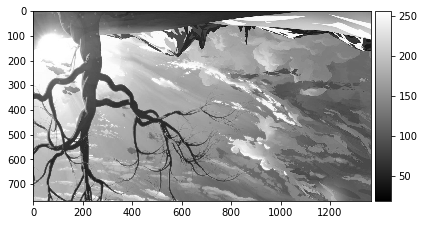

In [27]:
img2 = transform.rotate(img, 180, resize=True)
io.imshow(img2, cmap='gray')

In [ ]:
SIFT_summary1 = get_SIFT_data(img2, scale_lvls, sigmas, False)

In [ ]:
test_point = SIFT_summary1.sample(1)

In [ ]:
distances, indices = nn.kneighbors(np.array(test_point["Descriptor"].to_list()), n_neighbors=10)

In [ ]:
test_point

In [ ]:
SIFT_summary.loc[indices[0]]

In [39]:
x, y = test_point["Position"].to_list()[0]

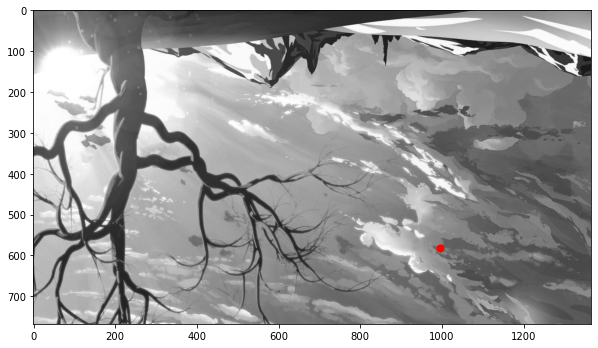

In [40]:
fig = plt.figure(figsize=(10, 8))
plt.imshow(img2, cmap='gray')  # Display the image
plt.scatter(x, y, color='red', s=50)  # Scatter plot the point (x, y) in red color
plt.show()

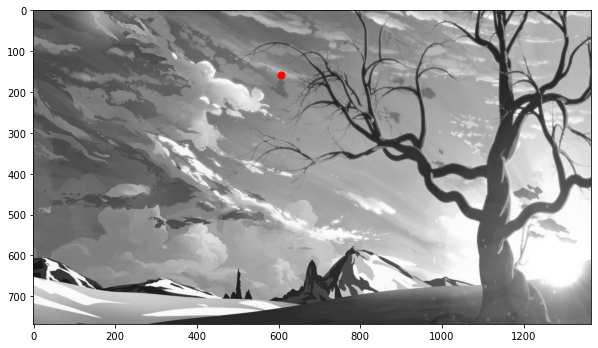

In [35]:
x, y = SIFT_summary.loc[indices[0]]["Position"].to_list()[0]
fig = plt.figure(figsize=(10, 8))
plt.imshow(img, cmap='gray')  # Display the image
plt.scatter(x, y, color='red', s=50)  # Scatter plot the point (x, y) in red color
plt.show()

In [36]:
test_point["Descriptor"]

10808    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010...
Name: Descriptor, dtype: object

In [37]:
SIFT_summary.loc[indices[0]]["Descriptor"]

3636     [0.0, 0.0, 0.0, 0.008713706298182623, 0.0, 0.0...
3633     [0.0, 0.0, 0.0, 0.011546661183370116, 0.0, 0.0...
3635     [0.0, 0.0, 0.0, 0.009636456161153287, 0.0, 0.0...
3634     [0.0, 0.0, 0.0, 0.01066978708340055, 0.0, 0.0,...
15148    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.042...
15150    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.042...
3637     [0.0, 0.0, 0.0, 0.008183506395345149, 0.0, 0.0...
3632     [0.0, 0.0, 0.0, 0.05611913901331921, 0.0, 0.0,...
15149    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.049...
746      [0.0, 0.0, 0.003761142592971592, 0.0, 0.0, 0.0...
Name: Descriptor, dtype: object

In [38]:
import cv2

# Load an image
image = cv2.imread('img.jpg', cv2.IMREAD_GRAYSCALE)

# Create scaled versions of the image
scaled_images = [
    cv2.resize(image, None, fx=0.5, fy=0.5),  # Scaled down (halved)
    cv2.resize(image, None, fx=1.5, fy=1.5)   # Scaled up (increased by 1.5x)
]

# Create SIFT object
sift = cv2.SIFT_create()

# Extract keypoints and descriptors for the original image
keypoints1, descriptors1 = sift.detectAndCompute(image, None)

for scaled_image in scaled_images:
    # Extract keypoints and descriptors for each scaled image
    keypoints2, descriptors2 = sift.detectAndCompute(scaled_image, None)

    # Perform matching or comparison between keypoints or descriptors
    # For example, count matches, compare locations, or analyze descriptors

    # Perform matching, location comparison, or descriptor analysis between keypoints1 and keypoints2
    # For instance, use a matching algorithm or check how many keypoints are shared between scales
